In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import os
import numpy as np
import random
from devai.utils.ml import Config
from devai.dataloaders import (
    ItemList,
    SplitData,
    random_splitter,
    label_by_func,
    parent_labeler,
    CategoryProcessor,
    compose,
)
from devai.callbacks import (
    AvgStatsCallback,
    ProgressCallback,
    Recorder,
    CudaCallbackMTL,
    TrainStatsCallback,
    sched_1cycle,
    DebugCallback,
    Callback,
)
from devai.metrics import accuracy
from devai.optimizers import adam_opt
from devai import Path
from devai.basics import Learner, CancelTrainException
from prepare_data import datasets
import mimetypes
from PIL import Image
from functools import partial
import torch
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch import nn
import mimetypes
import matplotlib.pyplot as plt
from model import ResCNNEncoder, DecoderRNN

<IPython.core.display.Javascript object>

# Config

In [3]:
config = Config(
    p_valid=0.3,
    res_size=224,
    num_classes=2,
    epochs=1,  # training epochs
    bs=2,
    max_lr=1e-3,
    phases=0.3,
    testing_pct=0.03,  # reduces the data to this percent if testing
)

<IPython.core.display.Javascript object>

# Dataloaders

In [4]:
image_extensions = set(
    k for k, v in mimetypes.types_map.items() if v.startswith("image/")
)
exclude = ["data", "fight", "nofight", "source_data"] + datasets


def show_image(im, figsize=(3, 3)):
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(im.permute(1, 2, 0))

<IPython.core.display.Javascript object>

In [5]:
def get_folders(data_path, **kwargs):
    data_path = Path(data_path)
    all_files = data_path.ls(**kwargs)
    image_folders = [f for f in all_files if f.is_dir()]
    return image_folders


class ImageFolderList(ItemList):
    @classmethod
    def from_files(
        cls, path, extensions=None, recursive=True, include=None, exclude=None, **kwargs
    ):
        return cls(
            get_folders(path, recursive=recursive, include=include, exclude=exclude),
            path,
            **kwargs
        )

    @staticmethod
    def sample_images(len_frames, n):
        sample_idxs = set()
        if len_frames <= n:
            return list(range(0, len_frames))
            raise ValueError("We got a problem")
        while len(sample_idxs) < n:
            sample_idxs.add(random.randint(0, len_frames - 1))
        return sample_idxs

    def _get(self, fn):
        frames = fn.ls(include=image_extensions, extension_filtering=True)
        frames = [frames[i] for i in self.sample_images(len(frames), 5)]
        x = []
        for img in frames:
            img = Image.open(img)
            x.append(compose(img, self.tfms))
        return torch.stack(x, 0) if self.tfms else x

<IPython.core.display.Javascript object>

In [6]:
# sample images # done!
# make rgb
class Transform:
    _order = 0


def make_rgb(item):
    return item.convert("RGB")


# Resize
class ResizeFixed(Transform):
    _order = 10

    def __init__(self, size):
        if isinstance(size, int):
            size = (size, size)
        self.size = size

    def __call__(self, item):
        return item.resize(self.size, PIL.Image.BILINEAR)


# etc?
def to_byte_tensor(item):
    res = torch.ByteTensor(torch.ByteStorage.from_buffer(item.tobytes()))
    w, h = item.size
    return res.view(h, w, -1).permute(2, 0, 1)


to_byte_tensor._order = 20


def to_float_tensor(item):
    return item.float().div_(255.0)


to_float_tensor._order = 30

<IPython.core.display.Javascript object>

In [7]:
tfms = [make_rgb, ResizeFixed(config.res_size), to_byte_tensor, to_float_tensor]
tfms_tv = [
    transforms.Resize([config.res_size, config.res_size]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]

<IPython.core.display.Javascript object>

In [8]:
il = ImageFolderList.from_files("data", exclude=exclude, tfms=tfms_tv)
if config.testing_pct:
    random.shuffle(il.items)
    il = il.new(il.items[: round(len(il) * config.testing_pct)])

<IPython.core.display.Javascript object>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


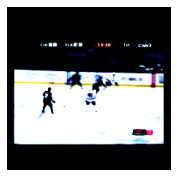

<IPython.core.display.Javascript object>

In [9]:
show_image(il[10][3])

In [10]:
random_splitter_func = partial(random_splitter, p_valid=config.p_valid)
sd = SplitData.split_by_func(il, random_splitter_func)

<IPython.core.display.Javascript object>

In [11]:
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())

<IPython.core.display.Javascript object>

In [12]:
# https://discuss.pytorch.org/t/error-expected-more-than-1-value-per-channel-when-training/26274/3
data = ll.to_databunch(config.bs, drop_last=True)

<IPython.core.display.Javascript object>

In [13]:
data.valid_ds

LabeledData
x: ImageFolderList (18 items)
[PosixPath('data/hockey/nofight/no89_xvid'), PosixPath('data/movies/nofight/23'), PosixPath('data/hockey/fight/fi350_xvid'), PosixPath('data/hockey/fight/fi400_xvid'), PosixPath('data/hockey/nofight/no472_xvid'), PosixPath('data/hockey/nofight/no74_xvid'), PosixPath('data/hockey/nofight/no247_xvid'), PosixPath('data/hockey/fight/fi488_xvid'), PosixPath('data/hockey/fight/fi243_xvid'), PosixPath('data/surv/nofight/nofi142')...]
Path: data
y: ItemList (18 items)
[0, 0, 1, 1, 0, 0, 0, 1, 1, 0...]
Path: data

<IPython.core.display.Javascript object>

# Model

In [14]:
class EncoderDecoder(nn.Module):
    def __init__(self, num_classes):
        super(EncoderDecoder, self).__init__()
        self.num_classes = num_classes
        self.cnn_encoder = ResCNNEncoder()
        self.rnn_decoder = DecoderRNN(num_classes=self.num_classes)

    def forward(self, x):
        x = self.cnn_encoder(x)
        x = self.rnn_decoder(x)
        return x

<IPython.core.display.Javascript object>

In [15]:
model = EncoderDecoder(num_classes=2)

<IPython.core.display.Javascript object>

In [16]:
def crnn_splitter(m):
    def _crnn_splitter(m, g1=[], g2=[]):
        """
        g1 = trainable weights 
        g2 = group which get a learning rate of 0
        """
        train = ["fc1", "fc2", "fc3", "bn1", "bn2", "rnn_decoder"]
        dont_train = ["resnet"]
        l = dict(m.named_children()).keys()
        for k in l:
            p = getattr(m, k).parameters()
            if k in dont_train:
                g1 += p
            elif k in train:
                g2 += p
            else:
                for ll in m.children():
                    _crnn_splitter(ll, g1, g2)
        return g1, g2

    return _crnn_splitter(m)

<IPython.core.display.Javascript object>

In [17]:
cbfs = [partial(AvgStatsCallback, [accuracy]), ProgressCallback, Recorder]
disc_lr_sched = sched_1cycle([0, config.max_lr], config.phases)
if torch.cuda.is_available():
    cbfs.append(CudaCallbackMTL)
cbfs.append(
    partial(
        TrainStatsCallback, 0.10, email=None
    )  # ("zodiac21zone", "devkosal@gmail.com"))
)

<IPython.core.display.Javascript object>

In [18]:
learn = Learner(
    model,
    data,
    F.cross_entropy,
    lr=config.max_lr,
    cb_funcs=cbfs,
    splitter=crnn_splitter,
    opt_func=adam_opt(),
)

<IPython.core.display.Javascript object>

In [19]:
# d1, d2 = crnn_splitter(model)

# len(d2), len(d1)

# from devai.utils.ml import CancelTrainException


# def _print_det(o):
#     print(
#         f"len_param_groups={[len(o.opt.param_groups[i]) for i in range(len(o.opt.param_groups))]}, and {o.opt.hypers}"
#     )
#     raise CancelTrainException()


# from types import SimpleNamespace

# cb_types = SimpleNamespace(**{o: o for o in Learner.ALL_CBS})
# learn.fit(1, disc_lr_sched + [DebugCallback(cb_types.after_batch, _print_det)])

<IPython.core.display.Javascript object>

In [20]:
learn.fit(config.epochs, cbs=disc_lr_sched)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.686359,0.576923,0.696054,0.500000,02:03


/Users/devsharma/Dropbox/Projects/devai/devai/optimizers.py:125: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1595629430416/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  state['grad_avg'].mul_(mom).add_(state['mom_damp'], p.grad.data)
INFO:root:epoch 0 stats for train iter 0 out of 13 iters are : {'loss': 0.7339, 'accuracy': 0.0}
INFO:root:epoch 0 stats for train iter 1 out of 13 iters are : {'loss': 0.7138, 'accuracy': 0.25}
INFO:root:epoch 0 stats for train iter 2 out of 13 iters are : {'loss': 0.7061, 'accuracy': 0.33333}
INFO:root:epoch 0 stats for train iter 3 out of 13 iters are : {'loss': 0.6974, 'accuracy': 0.5}
INFO:root:epoch 0 stats for train iter 4 out of 13 iters are : {'loss': 0.6967, 'accuracy': 0.5}
INFO:root:epoch 0 stats for train iter 5 out of 13 iters are :

<IPython.core.display.Javascript object>